<a href="https://colab.research.google.com/github/theroyakash/DeepDream/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Copyright 2020 theroyakash. All Rights Reserved.
#
# See privacy policy at https://www.iamroyakash.com/privacy
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
 
# ==============================================================================

In [ ]:
import numpy as np
import matplotlib as mpl
import tensorflow as tf
import IPython.display as display
from PIL import Image
import io
import requests

from tensorflow.keras.preprocessing import image

In [ ]:
url = 'https://images.unsplash.com/photo-1597202992582-9ee5c6672095'

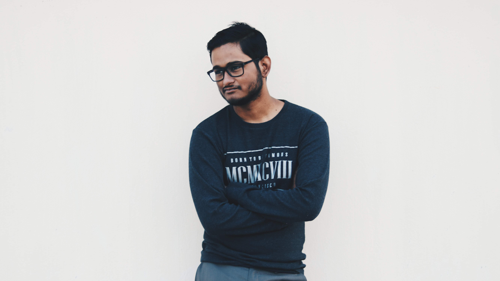

In [ ]:
def download(url, max_dim=None):
    '''
    Download an image and read it into a NumPy array.

        Args:
            - ``url``: URL of the image on the web
        
        Returns:
            - Numpy array of the image
    '''
    img = Image.open(io.BytesIO(requests.get(f'{url}').content))
    
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def deprocess(img):
    '''
    Normalizes image

        Args:
            - ``img``: PIL Image as image
    '''
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('<span>Photo by <a href="https://unsplash.com/@theroyakash?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">theroyakash</a> on <a href="https://unsplash.com/@theroyakash?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>'))

In [ ]:
# Downloading the base model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Activation Maximization for the following layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
    '''
    Pass forward the image through the model to retrieve the activations. Converts the image into a batch of size 1.

        Args:
            - img
            - model: Tensorflow Model
        
        Returns:
            - ``tf.reduce_sum(losses)``
    '''
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [ ]:
# Gradient ascent step

class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )

    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            
        return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_dream(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
            steps_remaining -= run_steps
            step += run_steps

            loss, img = deepdream(img, run_steps, tf.constant(step_size))
            
            display.clear_output(wait=True)
            show(deprocess(img))
            print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

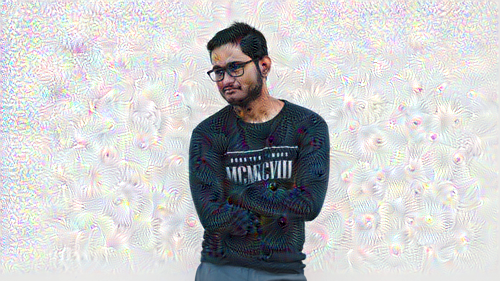

In [ ]:
dream_img = run_dream(img=original_img,steps=100, step_size=0.01)